# Root cause analysis in Microservices, using Causal Modeling 

References

1. RCD => https://github.com/azamikram/rcd

## Glossary 

- Conditional Independence Tests: A statistical test to determine if two variables are independent given a set of other variables.
- Intervention: A change in the value of a variable to observe the effect on other variables.
- Soft Intervention: A probabilistic change in the value of a variable to observe the effect on other variables.
- Causal Effect: The effect of one variable on another variable.
- Causal Graph: A graph that represents the causal relationships between variables.

## Introduction

Microservices are a popular architectural style for building large-scale applications. They are designed to be loosely coupled, independently deployable, and scalable. However, debugging and troubleshooting microservices can be challenging due to their distributed nature. In this notebook, we will explore how causal modeling can be used to analyze the root cause of issues in microservices.

## Problem Statement

Imagine you are a software engineer working on a microservices-based application. You receive a report that one of the services is experiencing performance issues. Users are complaining that the service is slow and unresponsive. Your task is to identify the root cause of the performance issues and fix them.

## Approach

We will use causal modeling to analyze the root cause of the performance issues in the microservice. Causal modeling is a technique that allows us to represent causal relationships between variables in a graphical form. By analyzing the causal relationships between variables, we can identify the root cause of the issues. Once root cause is identify we coorelated with other metadata like logs, code, documentation to prescribe a recommended action

## Steps

Note: We will use the RCD library for causal modeling in this notebook.


1. Define the variables: Identify the variables that are relevant to the performance issues in the microservice.
2. Build the causal graph: Construct a causal graph that represents the causal relationships between the variables.
3. Identify the root cause: Analyze the causal graph to identify the root cause of the performance issues.
4. Prescribe a recommended action: Based on the root cause, prescribe a recommended action to fix the performance issues.


RCD is a Python library that provides tools for causal modeling and root cause analysis. It allows you to define causal graphs, perform causal inference, and analyze the root cause of issues in complex systems. In this notebook, we will use RCD to analyze the root cause of performance issues in a microservices-based application.




_Note: Since we are overriding files in the virtual environment, the below path should point to that virtual environment. <br/>
in this case, the virtual environment is located at /home/azureuser/cloudfiles/code/.venv/lib/python3.8/site-packages/_


In [1]:
%%bash
cp pyAgrum/lib/image.py /home/azureuser/cloudfiles/code/.venv/lib/python3.8/site-packages/pyAgrum/lib/
cp causallearn/search/ConstraintBased/FCI.py /home/azureuser/cloudfiles/code/.venv/lib/python3.8/site-packages/causallearn/search/ConstraintBased/
cp causallearn/utils/Fas.py /home/azureuser/cloudfiles/code/.venv/lib/python3.8/site-packages/causallearn/utils/
cp causallearn/utils/PCUtils/SkeletonDiscovery.py /home/azureuser/cloudfiles/code/.venv/lib/python3.8/site-packages/causallearn/utils/PCUtils/
cp causallearn/graph/GraphClass.py /home/azureuser/cloudfiles/code/.venv/lib/python3.8/site-packages/causallearn/graph/

In [57]:
import time
import argparse
import numpy as np
# Disable warnings from sklearn
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import KBinsDiscretizer
from causallearn.utils.cit import chisq
from causallearn.utils.PCUtils import SkeletonDiscovery
from matplotlib import pyplot as plt

In [92]:

# Note: Some of the functions defined here are only used for data
# from sock-shop or real-world application.

CI_TEST = chisq
START_ALPHA = 0.001
ALPHA_STEP = 0.1
ALPHA_LIMIT = 1
VERBOSE = True
F_NODE = 'F-node'

def get_node_name(node):
    return f"X{node}"

def drop_constant(df):
    return df.loc[:, (df != df.iloc[0]).any()]

# Only used for sock-shop and real outage datasets
def preprocess(n_df, a_df, per):
    _process = lambda df: _select_lat(_scale_down_mem(_rm_time(df)), per)

    n_df = _process(n_df)
    a_df = _process(a_df)
    
    n_df = drop_constant(n_df)
    a_df = drop_constant(a_df)

    n_df, a_df = _match_columns(n_df, a_df)

    df = _select_useful_cols(add_fnode(n_df, a_df))
    n_df = df[df[F_NODE] == '0'].drop(columns=[F_NODE])
    a_df = df[df[F_NODE] == '1'].drop(columns=[F_NODE])

    return (n_df, a_df)

def load_datasets(normal, anomalous, verbose=VERBOSE):
    if verbose:
        print('Loading the dataset ...')
    normal_df = pd.read_csv(normal)
    anomalous_df = pd.read_csv(anomalous)
    return (normal_df, anomalous_df)

def add_fnode(normal_df, anomalous_df):
    normal_df[F_NODE] = '0'
    anomalous_df[F_NODE] = '1'
    return pd.concat([normal_df, anomalous_df])

# Run PC (only the skeleton phase) on the given dataset.
# The last column of the data *must* be the F-node
def run_pc(data, alpha, localized=False, labels={}, mi=[], verbose=VERBOSE):
    if labels == {}:
        labels = {i: name for i, name in enumerate(data.columns)}

    np_data = data.to_numpy()
    if localized:
        f_node = np_data.shape[1] - 1
        # Localized PC
        cg = SkeletonDiscovery.local_skeleton_discovery(np_data, f_node, alpha,
                                                        indep_test=CI_TEST, mi=mi,
                                                        labels=labels, verbose=verbose)
    else:
        cg = SkeletonDiscovery.skeleton_discovery(np_data, alpha, indep_test=CI_TEST,
                                                  background_knowledge=None,
                                                  stable=False, verbose=verbose,
                                                  labels=labels, show_progress=False)

    cg.draw_pydot_graph()
    cg.to_nx_graph()
    return cg

def get_fnode_child(G):
    return [*G.successors(F_NODE)]

def save_graph(graph, file):
    nx.draw_networkx(graph)
    plt.savefig(file)

def pc_with_fnode(normal_df, anomalous_df, alpha, bins=None,
                  localized=False, verbose=VERBOSE):
    data = _preprocess_for_fnode(normal_df, anomalous_df, bins)
    cg = run_pc(data, alpha, localized=localized, verbose=verbose)
    return cg.nx_graph

# Equivelant to \Psi-PC from the main paper
def top_k_rc(normal_df, anomalous_df, bins=None, mi=[],
             localized=False, start_alpha=None, min_nodes=-1,
             verbose=VERBOSE):
    if 0 in [len(normal_df.columns), len(anomalous_df.columns)]:
        return ([], None, [], 0)
    data = _preprocess_for_fnode(normal_df, anomalous_df, bins)

    if min_nodes == -1:
        # Order all nodes (if possible) except F-node
        min_nodes = len(data.columns) - 1
    assert(min_nodes < len(data))

    G = None
    no_ci = 0
    i_to_labels = {i: name for i, name in enumerate(data.columns)}
    labels_to_i = {name: i for i, name in enumerate(data.columns)}

    _preprocess_mi = lambda l: [labels_to_i.get(i) for i in l]
    _postprocess_mi = lambda l: [i_to_labels.get(i) for i in list(filter(None, l))]
    processed_mi = _preprocess_mi(mi)
    _run_pc = lambda alpha: run_pc(data, alpha, localized=localized, mi=processed_mi,
                                   labels=i_to_labels, verbose=verbose)

    rc = []
    _alpha = START_ALPHA if start_alpha is None else start_alpha
    for i in np.arange(_alpha, ALPHA_LIMIT, ALPHA_STEP):
        cg = _run_pc(i)
        
        G = cg.nx_graph
        no_ci += cg.no_ci_tests

        if G is None: continue

        f_neigh = get_fnode_child(G)
        new_neigh = [x for x in f_neigh if x not in rc]
        if len(new_neigh) == 0: continue
        else:
            f_p_values = cg.p_values[-1][[labels_to_i.get(key) for key in new_neigh]]
            rc += _order_neighbors(new_neigh, f_p_values)

        if len(rc) == min_nodes: break

    return (rc, G, _postprocess_mi(cg.mi), no_ci)

def _order_neighbors(neigh, p_values):
    _neigh = neigh.copy()
    _p_values = p_values.copy()
    stack = []

    while len(_neigh) != 0:
        i = np.argmax(_p_values)
        node = _neigh[i]
        stack = [node] + stack
        _neigh.remove(node)
        _p_values = np.delete(_p_values, i)
    return stack

_rm_time = lambda df: df.loc[:, ~df.columns.isin(['time'])]
_list_intersection = lambda l1, l2: [x for x in l1 if x in l2]

def _preprocess_for_fnode(normal_df, anomalous_df, bins):
    df = add_fnode(normal_df, anomalous_df)
    if df is None: return None

    return _discretize(df, bins) if bins is not None else df

def _select_useful_cols(df):
    # get the columns that have a standard deviation greater than 1
    # In statistics, a standard deviation (SD) greater than 1 indicates that data points are spread out over a wider range, which is a sign of high variability.
    i = df.loc[:, df.columns != F_NODE].std() > 1
    cols = i[i].index.tolist()
    cols.append(F_NODE)
    if len(cols) == 1:
        return None
    elif len(cols) == len(df.columns):
        return df

    return df[cols]

# Only select the metrics that are in both datasets
def _match_columns(n_df, a_df):
    cols = _list_intersection(n_df.columns, a_df.columns)
    return (n_df[cols], a_df[cols])

# Convert all memeory columns to MBs
def _scale_down_mem(df):
    def update_mem(x):
        if not x.name.endswith('_mem'):
            return x
        x /= 1e6
        x = x.astype(int)
        return x

    return df.apply(update_mem)

# Select all the non-latency columns and only select latecy columns
# with given percentaile
def _select_lat(df, per):
    return df.filter(regex=(".*(?<!lat_\d{2})$|_lat_" + str(per) + "$"))

# NOTE: THIS FUNCTION THROWS WARNGINGS THAT ARE SILENCED!
def _discretize(data, bins):
    d = data.iloc[:, :-1]
    discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    discretizer.fit(d)
    disc_d = discretizer.transform(d)
    disc_d = pd.DataFrame(disc_d, columns=d.columns.values.tolist())
    disc_d[F_NODE] = data[F_NODE].tolist()

    for c in disc_d:
        disc_d[c] = disc_d[c].astype(int)

    return disc_d


In [93]:
SRC_DIR = 'sock-shop-data/orders-cpu/1/'
(normal_df, anomalous_df) = load_datasets(SRC_DIR + 'normal.csv', SRC_DIR + 'anomalous.csv')
print(normal_df.columns)

Loading the dataset ...
Index(['time', 'carts_cpu', 'carts-db_cpu', 'catalogue_cpu',
       'catalogue-db_cpu', 'front-end_cpu', 'orders_cpu', 'orders-db_cpu',
       'payment_cpu', 'queue-master_cpu', 'rabbitmq_cpu', 'shipping_cpu',
       'user_cpu', 'user-db_cpu', 'carts_mem', 'carts-db_mem', 'catalogue_mem',
       'catalogue-db_mem', 'front-end_mem', 'orders_mem', 'orders-db_mem',
       'payment_mem', 'queue-master_mem', 'rabbitmq_mem', 'shipping_mem',
       'user_mem', 'user-db_mem', 'carts_lod', 'catalogue_lod', 'shipping_lod',
       'carts_lat_50', 'catalogue_lat_50', 'shipping_lat_50', 'carts_lat_90',
       'catalogue_lat_90', 'shipping_lat_90', 'carts_lat_99',
       'catalogue_lat_99', 'shipping_lat_99'],
      dtype='object')


In [94]:
# plt.figure(figsize=(10, 6))
# column = 'orders-db_mem'
# normal_df[column].plot()

In [95]:
# anomalous_df[column].plot()

In [96]:
n_df, a_df = preprocess(normal_df, anomalous_df, 90)
n_df.head()

,carts-db_cpu,front-end_cpu,orders_cpu,carts-db_mem,front-end_mem,orders_mem,user-db_mem
0,77.819428,10.526759,0.743285,224,113,328,256
1,77.819428,13.151325,0.743285,224,113,328,256
2,75.865452,13.151325,0.743285,225,113,328,256
3,75.865452,13.151325,0.743285,225,113,328,256
4,75.865452,13.151325,0.743285,225,113,328,256


In [97]:
a_df.head()

,carts-db_cpu,front-end_cpu,orders_cpu,carts-db_mem,front-end_mem,orders_mem,user-db_mem
0,61.838952,13.953486,100.131127,172,117,338,339
1,63.554104,10.947391,100.131127,172,117,338,339
2,77.181845,14.163028,100.131127,172,117,338,339
3,77.181845,14.163028,99.957875,172,117,338,339
4,77.181845,13.646239,99.957875,172,118,338,339


In [98]:
VERBOSE = True
k = 3
SEED = 420
BINS = None

# LOCAL_ALPHA has an effect on execution time. Too strict alpha will produce a sparse graph
# so we might need to run phase-1 multiple times to get up to k elements. Too relaxed alpha
# will give dense graph so the size of the separating set will increase and phase-1 will
# take more time.
# We tried a few different values and found that 0.01 gives the best result in our case
# (between 0.001 and 0.1).
LOCAL_ALPHA = 0.01
DEFAULT_GAMMA = 5
local = True

In [99]:
# Split the dataset into multiple subsets
def create_chunks(df, gamma):
    chunks = list()
    names = np.random.permutation(df.columns)
    for i in range(df.shape[1] // gamma + 1):
        chunks.append(names[i * gamma:(i * gamma) + gamma])

    if len(chunks[-1]) == 0:
        chunks.pop()
    return chunks

print('Creating chunks...')
chunks = create_chunks(normal_df, DEFAULT_GAMMA)
print(chunks)

Creating chunks...
[array(['user-db_mem', 'shipping_lat_50', 'user_mem', 'carts_lat_90',
       'carts_cpu'], dtype=object), array(['rabbitmq_cpu', 'catalogue_mem', 'queue-master_mem', 'orders_mem',
       'catalogue_cpu'], dtype=object), array(['catalogue_lat_90', 'orders_cpu', 'front-end_mem', 'user_cpu',
       'shipping_lat_90'], dtype=object), array(['payment_mem', 'shipping_lod', 'catalogue-db_mem', 'carts_mem',
       'catalogue-db_cpu'], dtype=object), array(['time', 'carts_lat_99', 'orders-db_cpu', 'carts_lod',
       'shipping_mem'], dtype=object), array(['orders-db_mem', 'shipping_cpu', 'queue-master_cpu',
       'catalogue_lat_99', 'carts_lat_50'], dtype=object), array(['carts-db_mem', 'rabbitmq_mem', 'catalogue_lod', 'user-db_cpu',
       'front-end_cpu'], dtype=object), array(['carts-db_cpu', 'shipping_lat_99', 'payment_cpu',
       'catalogue_lat_50'], dtype=object)]


Created 2 subsets
F-node dep orders_cpu | [] with p-value 4.4941755551198884e-54
F-node dep orders_mem | [] with p-value 1.4832970597866433e-127
F-node dep carts-db_mem | [] with p-value 2.2616195497543398e-126
F-node dep front-end_mem | [] with p-value 3.3472351366689533e-124
F-node dep user-db_mem | [] with p-value 2.9270562071281615e-125
F-node ind orders_mem | ['front-end_mem'] with p-value 1
F-node ind user-db_mem | ['front-end_mem'] with p-value 1
F-node ind front-end_mem | ['orders_cpu'] with p-value 1
F-node ind orders_cpu | ['carts-db_mem'] with p-value 1


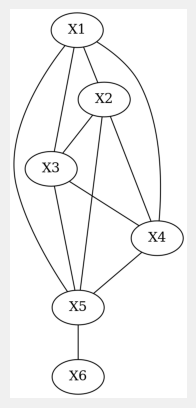

F-node dep carts-db_cpu | [] with p-value 2.0613361997171212e-49
F-node dep front-end_cpu | [] with p-value 1.8941205142124402e-61
F-node ind front-end_cpu | ['carts-db_cpu'] with p-value 1


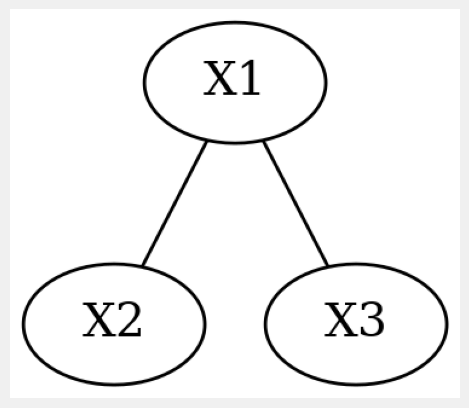

Output of individual chunk [['carts-db_mem'], ['carts-db_cpu']]
Total nodes in mi => 0 | []
Level-0: variables 2 | time 0.47905564308166504
F-node dep carts-db_cpu | [] with p-value 2.0613361997171212e-49
F-node dep carts-db_mem | [] with p-value 2.2616195497543398e-126
F-node ind carts-db_mem | ['carts-db_cpu'] with p-value 1

F-node dep carts-db_mem | [] with p-value 2.2616195497543398e-126
F-node dep carts-db_cpu | [] with p-value 2.0613361997171212e-49
F-node ind carts-db_mem | ['carts-db_cpu'] with p-value 1

F-node dep carts-db_mem | [] with p-value 2.2616195497543398e-126
F-node dep carts-db_cpu | [] with p-value 2.0613361997171212e-49
F-node ind carts-db_mem | ['carts-db_cpu'] with p-value 1

F-node dep carts-db_cpu | [] with p-value 2.0613361997171212e-49
F-node dep carts-db_mem | [] with p-value 2.2616195497543398e-126
F-node ind carts-db_cpu | ['carts-db_mem'] with p-value 1


{'time': 0.49428415298461914, 'root_cause': ['carts-db_cpu', 'carts-db_mem'], 'tests': 24}


In [100]:

def run_level(normal_df, anomalous_df, gamma, localized, bins, verbose):
    ci_tests = 0
    chunks = create_chunks(normal_df, gamma)
    if verbose:
        print(f"Created {len(chunks)} subsets")

    f_child_union = list()
    mi_union = list()
    f_child = list()
    for c in chunks:
        # Try this segment with multiple values of alpha until we find at least one node
        rc, g, mi, ci = top_k_rc(normal_df.loc[:, c],
                                   anomalous_df.loc[:, c],
                                   bins=bins,
                                   localized=localized,
                                   start_alpha=LOCAL_ALPHA,
                                   min_nodes=1,
                                   verbose=verbose)
        f_child_union += rc
        mi_union += mi
        ci_tests += ci
        if verbose:
            f_child.append(rc)

    if verbose:
        print(f"Output of individual chunk {f_child}")
        print(f"Total nodes in mi => {len(mi_union)} | {mi_union}")

    return f_child_union, mi_union, ci_tests

def run_multi_phase(normal_df, anomalous_df, gamma, localized, bins, verbose):
    f_child_union = normal_df.columns
    mi_union = []
    i = 0
    prev = len(f_child_union)

    # Phase-1
    ci_tests = 0
    while True:
        start = time.time()
        f_child_union, mi, ci = run_level(normal_df.loc[:, f_child_union],
                                          anomalous_df.loc[:, f_child_union],
                                          gamma, localized, bins, verbose)
        if verbose:
            print(f"Level-{i}: variables {len(f_child_union)} | time {time.time() - start}")
        i += 1
        mi_union += mi
        ci_tests += ci
        # Phase-1 with only one level
        # break

        len_child = len(f_child_union)
        # If found gamma nodes or if running the current level did not remove any node
        if len_child <= gamma or len_child == prev: break
        prev = len(f_child_union)

    # Phase-2
    mi_union = []
    new_nodes = f_child_union
    rc, g, mi, ci = u.top_k_rc(normal_df.loc[:, new_nodes],
                               anomalous_df.loc[:, new_nodes],
                               bins=bins,
                               mi=mi_union,
                               localized=localized,
                               verbose=verbose)
    print(g)
    ci_tests += ci
    return rc, ci_tests

def rca_with_rcd(normal_df, anomalous_df, bins,
                 gamma=DEFAULT_GAMMA, localized=False, verbose=VERBOSE):
    start = time.time()
    rc, ci_tests = run_multi_phase(normal_df, anomalous_df, gamma, localized, bins, verbose)
    end = time.time()

    return {'time': end - start, 'root_cause': rc, 'tests': ci_tests}

def main_top_k_rc(normal_df, anomalous_df, k, bins,
             gamma=DEFAULT_GAMMA, seed=SEED, localized=False, verbose=VERBOSE):
    np.random.seed(seed)
    result = rca_with_rcd(normal_df, anomalous_df, bins, gamma, localized, verbose)
    return {**result, 'root_cause': result['root_cause'][:k]}


result = main_top_k_rc(n_df, a_df, k=k, bins=BINS, localized=local, verbose=VERBOSE)
print(result)